In [68]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
print(tf.__version__)

2.9.1


In [5]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 20s 0us/step


In [8]:
data_dir

WindowsPath('C:/Users/HP/.keras/datasets/flower_photos')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


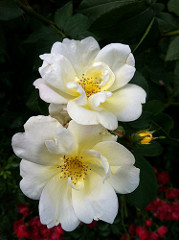

In [14]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### 외부 이미지를 읽고 모델링

- 이미지를 w,b를 갱신하는 batch단위로 읽어서 신경망에다가 전달함.
    - batch단위로 데이터셋을 load해서, x, y로 제작
        - x데이터 전제조건: 가로, 세로 사이즈가 같아야함, 스케일링 등의 전처리 필요
            - 예) 배치가 5임 [[1번 이미지], [2번 이미지], [3번 이미지]]
                - [[[r, g, b], [r, g, b]], [[r, g, b], [r, g, b]]] => 1번 이미지
                - [[[r, g, b], [r, g, b]], [[r, g, b], [r, g, b]]] => 2번 이미지
                - [[[r, g, b], [r, g, b]], [[r, g, b], [r, g, b]]] => 3번 이미지
        - y데이터 전제조건: 레이블(숫자)이어야함.
            - [1번 레이블, 2번 레이블, 3번 레이블]

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [33]:
# train_size / batch_size
len(train_ds)

92

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


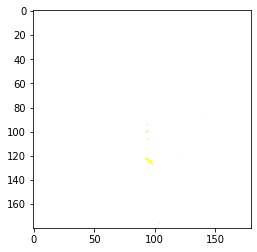

In [34]:
for x in train_ds.take(1):
    img, labels = x

labels
plt.imshow(img[1])

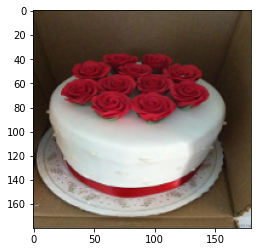

In [35]:
plt.imshow(img[0].numpy().astype("uint8"))

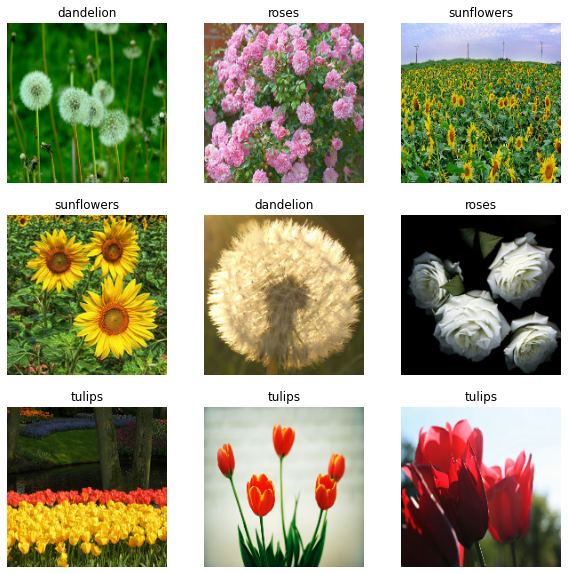

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:
# image_batch는 (32, 180, 180, 3) 형상의 텐서이며,
# 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄).
# label_batch는 형상 (32,)의 텐서이며 32개 이미지에 해당하는 레이블입니다.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [39]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. /
                                                                           255)

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [41]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 3, 4, 0, 0, 1, 0, 4, 1, 4, 3, 1, 4, 1, 2, 4, 3, 1, 4, 2, 4, 0,
       0, 1, 3, 3, 4, 4, 1, 1, 0, 4])>

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
num_classes = 5

model = tf.keras.Sequential([
    # scaling
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / 255, input_shape=(img_height, img_width, 3)),

    # cnn
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # 완전연결층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [53]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 33s 358ms/step - loss: 1.2639 - accuracy: 0.4567 - val_loss: 1.1300 - val_accuracy: 0.5286
Epoch 2/10
92/92 [==============================] - 32s 352ms/step - loss: 1.0209 - accuracy: 0.5978 - val_loss: 1.0146 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 34s 367ms/step - loss: 0.8619 - accuracy: 0.6625 - val_loss: 0.9325 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 33s 361ms/step - loss: 0.6666 - accuracy: 0.7446 - val_loss: 0.9381 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 33s 354ms/step - loss: 0.4702 - accuracy: 0.8331 - val_loss: 1.0740 - val_accuracy: 0.6063
Epoch 6/10
92/92 [==============================] - 33s 354ms/step - loss: 0.3903 - accuracy: 0.8624 - val_loss: 1.2111 - val_accuracy: 0.5899
Epoch 7/10
92/92 [==============================] - 33s 355ms/step - loss: 0.4117 - accuracy: 0.8478 - val_loss: 1.2974 - val_accuracy: 0.5967

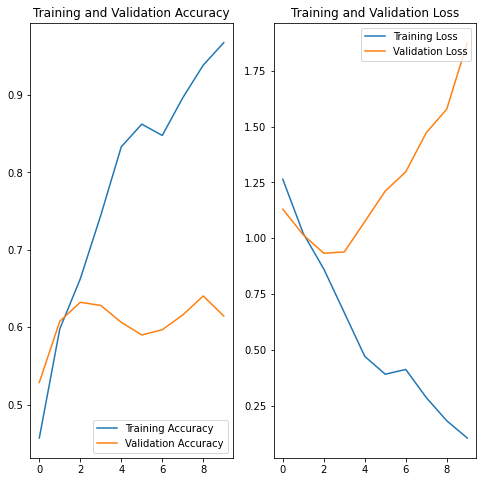

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
# 데이터 증강
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

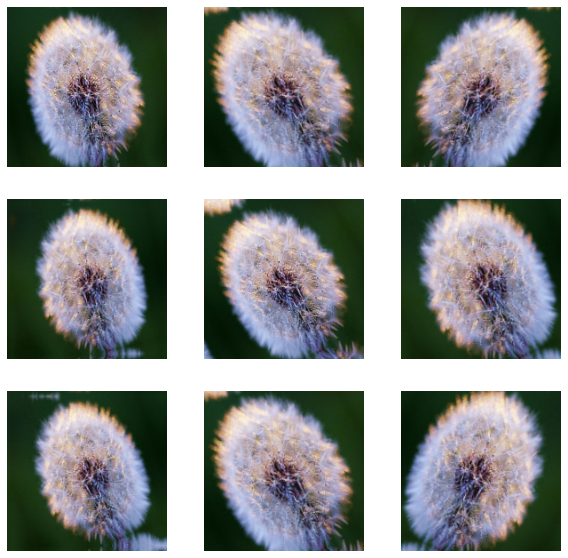

In [58]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [61]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [64]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 32s 335ms/step - loss: 1.3218 - accuracy: 0.4384 - val_loss: 1.0865 - val_accuracy: 0.5477
Epoch 2/15
92/92 [==============================] - 31s 338ms/step - loss: 1.0427 - accuracy: 0.5732 - val_loss: 0.9956 - val_accuracy: 0.6090
Epoch 3/15
92/92 [==============================] - 30s 331ms/step - loss: 0.9594 - accuracy: 0.6247 - val_loss: 0.9395 - val_accuracy: 0.6199
Epoch 4/15
92/92 [==============================] - 31s 335ms/step - loss: 0.9022 - accuracy: 0.6451 - val_loss: 0.8732 - val_accuracy: 0.6485
Epoch 5/15
92/92 [==============================] - 32s 347ms/step - loss: 0.8212 - accuracy: 0.6798 - val_loss: 0.8145 - val_accuracy: 0.6662
Epoch 6/15
92/92 [==============================] - 31s 340ms/step - loss: 0.7919 - accuracy: 0.6952 - val_loss: 0.8129 - val_accuracy: 0.6717
Epoch 7/15
92/92 [==============================] - 32s 349ms/step - loss: 0.7604 - accuracy: 0.7112 - val_loss: 0.7838 - val_accuracy: 0.6894

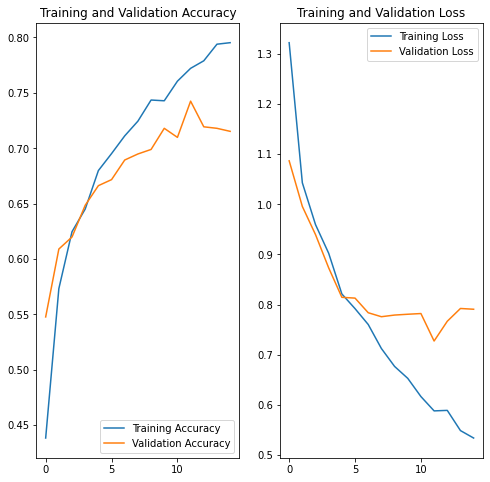

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(sunflower_path,
                                            target_size=(img_height,
                                                         img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".
      format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 117ms/step
This image most likely belongs to sunflowers with a 86.18 percent confidence.


---

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

In [ ]:
class_names = np.array(
    sorted([
        item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"
    ]))
print(class_names)

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())